<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера</b>
    
Привет! Меня зовут Светлана Носова, я буду проверять твой проект. Если не против, давай общаться на «ты». Если тебе такой стиль общения не нравится, напиши об этом, будем на «вы».

Сразу хочу обратить внимание на цветовую разметку.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Зеленым отмечены отличные решения и идеи, которые можно и нужно использовать в будущем.
</div>
    
<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Желтым отмечено то, что можно или нужно оптимизировать, в зависимости от контекста.</div>    
    
<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Красным  обозначены пропущенные пункты задания и ошибки, которые обязательно надо будет исправить, чтобы результаты были верные.</div>
    
**Ответы на мои комментарии или доработки по моим рекомендациям попрошу выделить каким-нибудь цветом, кроме перечисленных.**
Также я попрошу тебя **не менять, не передвигать и не удалять мои комментарии**, чтобы при последующей проверке мне было проще ориентироваться.
    
Кроме того, комментарии у меня обозначены как заголовки. Это сбивает содержание, но при последующей проверке я могу снять с них заголовок, если тебе так будет удобнее. При этом они удобны, поскольку ты сразу можешь перейти к ним.   
        
<hr>
    
**По проекту:** работа очень объемная и непростая, ты молодец. На первый взгляд, структура хорошая, много анализа и выводов. Хорошо проработаны пропущенные значения. К сожалению, указан локальный путь к файлу, поэтому я не могу проверить работу полность. Посмотрела лишь код заполнения пропусков и комментарии к нему. Буду ждать работу на повторное ревью.
    

</div>    

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера</b>
    
Вводный параграф это неотъемлемая часть любого проекта, отчета, презентации или статьи. Будет очень здорово, если ты добавишь постановку задачи: краткое ее описание и описание данных.
</div>

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера 2</b>
    
Я оставила новые комментарии с цифрой 2, а со старых сняла заголовки, чтобы  не мешали. Работа хорошая, критичных замечаний у меня нет, есть лишь рекомендации на будущее:
    
- Не стесняйся подкреплять вывод полученными ранее результатами. Это нужно не столько для эстетичности твоей работы/презентации, сколько для того, чтобы не давать заказчику ни единго шанса неверно интерпретировать результаты.
    
    
- Старайся добавлять подписи на графики и сразу их комментировать.
    
    
- Коэфф-т корреляции Пирсона это коэфф-т линейной связи. Ее отсутствие не влечет отсутствие связи как таковой, поскольку последняя может быть нелинейной. Ты правильно делаешь, что рассматриваешь еще и графики. Не забывай об этом и в дальнейшем :)
    

    
    
По проекту у меня вопросов больше нет, поэтому я могу его принять. Желаю успехов и хороших выходных :)     
</div>

<strong><em><h1>Step 1 and Step 2. Opening the table and preprocessing the data</em></strong></h1>

<h4><div class="alert alert-block alert-info">
To start, let's import the table and analyze which columns have missing values.</div></h4>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
real = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
real.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<div class="alert alert-block alert-info">
    <h5>Comments on the table:</h5>
    
1) The total number of rows is 23,699, which is confirmed by the large number of columns with the same count.
    
2) "last price" needs to be converted to an integer format since dealing with decimals in real estate can be confusing.

3) "first_day_exposition" should be converted to a time format and rounded to the nearest day.
    
4) "ceiling_height" has missing values for more than half of the height indicators. We need to find analogs based on the address and fill in the height where possible.
    
5) "floors_total" has a small number of missing values.
    
6) "living_area" has missing values relative to the number of columns. There is a hypothesis that the absence of values in the living area and kitchen area may be related to the boolean parameter "open-plan." If the layout is open-plan, there will be no kitchen or living area.
    
7) "is_apartment" has too few filled values. It is likely that changing the dtype to bool will resolve the issue.
    
8) "kitchen_area" has no missing values. We need to check if they are related to missing values in the living area. There is a hypothesis that in some apartments, the kitchen is combined with the living room, so there is no separate kitchen area. We will investigate further.
    
9) "balcony" has more than half of the values not filled in. Most likely, where there is no balcony, nothing was recorded.
    
10) "locality_name" has a small number of missing values. Since this parameter is important, we will omit the missing values.
    
11) "airport_nearest," "parks_around3000," "ponds_around3000," "parks_nearest," "ponds_nearest," and "cityCenters_nearest" have a large number of missing values, which is likely due to human error during ad posting. I will try to find this information and incorporate it into the table.
    
12) "days_exposition" has almost 3000 missing values. I will try to fill them with the average value of similar objects with a known duration.</div>

<div class="alert alert-block alert-info">
    <h5>Let's start with simple actions:</h5>
2) Changing the data type of "last_price" to int.
7) Changing the data type of "is_apartment" to bool.
</div>

In [ ]:
real['is_apartment'] = real['is_apartment'].astype(bool)
real['last_price'] = real['last_price'].astype(int)
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<div class="alert alert-block alert-info">
3) Converting "first_day_exposition" to a datetime format and rounding it to the nearest day.</div>

In [ ]:
real['time_to_day'] = pd.to_datetime(real['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#real['time_to_day'] = real['first_day_exposition'].real.round('1D')
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19


<div class="alert alert-block alert-info">
Note: Rounding was not necessary since the time was already set to zeros in all cases. The system automatically removed the hours.</div>

<div class="alert alert-block alert-info">
4) "ceiling_height" has a large number of missing values. Let's look for correlations:</div>

In [ ]:
real['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [ ]:
real['ceiling_height'].loc[real['ceiling_height'] > 5].value_counts()
#.sort_values(by = 'ceiling_height', ascending = True)

27.0     8
25.0     7
8.0      3
5.3      2
32.0     2
20.0     1
10.3     1
27.5     1
5.8      1
22.6     1
6.0      1
8.3      1
14.0     1
5.5      1
5.2      1
26.0     1
24.0     1
5.6      1
100.0    1
Name: ceiling_height, dtype: int64

<div class="alert alert-block alert-info">
By examining the boundary between reasonable and unreasonable values, it appears to fall between 5.2 (an expensive 300 sqm apartment in St. Petersburg) and 5.3 (50 sqm with such high ceilings is unreasonable).
The hypothesis is as follows: values in the range of 20.0 to 32.0 can be explained by incorrect placement of the decimal point, so these values should be corrected by dividing them by 10.</div>

In [ ]:
real.query('ceiling_height == 27.0').sort_values(by = 'ceiling_height', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
4876,7,3000000,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,True,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0,2017-09-27
5246,0,2500000,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,True,...,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,2017-10-13
5807,17,8150000,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,True,...,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,2019-01-09
10773,8,3800000,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0,2017-10-13
17857,1,3900000,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,...,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0,2017-12-22
20478,11,8000000,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,True,...,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0,2017-07-18
21824,20,2450000,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,...,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-12
22938,14,4000000,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,...,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0,2018-03-15


<div class="alert alert-block alert-info">
In apartments with 27-meter ceilings, nothing unusual was observed - typical area, typical price. Therefore, the hypothesis is confirmed, and we will make the change accordingly.</div>

In [ ]:
import numpy as np

In [ ]:
#real2 = real['ceiling_height']/10
#real1 = real['ceiling_height'].query>
#real['ceiling_height'] = np.where(real['ceiling_height']>20, real2)
#real.head()
real.loc[real['ceiling_height'] > 23 , 'ceiling_height'] /= 10
real.query('ceiling_height > 23')



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day


<div class="alert alert-block alert-info">
We have eliminated values with human error, but there are still a few values in the range beyond 5.3 that cannot be explained reasonably. Therefore, it is more reliable to "zero" them out and then fill them with the median based on several features.</div>

In [ ]:
real_see = real.query('ceiling_height > 5.2').sort_values(by = 'ceiling_height', ascending = False)
real_see

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
20507,12,5950000,60.0,2018-02-19T00:00:00,2,22.6,14.0,35.0,11,True,...,1.0,Санкт-Петербург,27028.0,12570.0,0.0,NaN,0.0,NaN,40.0,2018-02-19
17496,15,6700000,92.9,2019-02-19T00:00:00,3,20.0,17.0,53.2,14,True,...,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN,2019-02-19
15061,19,5600000,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,True,...,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,2018-05-11
22309,20,5300000,45.0,2017-09-30T00:00:00,1,10.3,16.0,15.5,15,True,...,NaN,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0,2017-09-30
22869,0,15000000,25.0,2018-07-25T00:00:00,1,10.0,5.0,14.0,5,True,...,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,2018-07-25
5863,20,5650000,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,True,...,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0,2018-08-15
3474,3,1400000,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,...,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0,2018-03-16
15743,14,5600000,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,True,...,NaN,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0,2016-11-11
17442,0,5350000,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.0,2,True,...,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0,2015-06-16
20264,17,119000000,187.6,2017-07-10T00:00:00,4,6.0,7.0,147.0,7,True,...,NaN,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0,2017-07-10


In [ ]:
real['ceiling_height'] = np.where(real.ceiling_height > 5.2, 0, real.ceiling_height)



In [ ]:
real['ceiling_height'].isna().sum()

9195

<div class="alert alert-block alert-info">
Thus, we have a large number of NaN values, which we will fill with the mean value.</div>

<div class="alert alert-block alert-info">
We will apply the transform method to several columns with complete data to achieve maximum data recovery.</div>

In [ ]:
real['ceiling_height'] = real['ceiling_height'].fillna(real.groupby('total_area')['ceiling_height'].transform('median'))
real.head(8)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.700,16.0,51.0,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.700,11.0,18.6,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.600,5.0,34.3,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.0,2015-07-24T00:00:00,3,3.140,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.030,14.0,32.0,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19
5,10,2890000,30.4,2018-09-10T00:00:00,1,2.520,12.0,14.4,5,True,...,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2018-09-10
6,6,3700000,37.3,2017-11-02T00:00:00,1,2.650,26.0,10.6,6,True,...,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,2017-11-02
7,5,7915000,71.6,2019-04-18T00:00:00,2,2.775,24.0,NaN,22,True,...,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2019-04-18


In [ ]:
real['ceiling_height'].isna().sum()

627

In [ ]:
real['ceiling_height'] = real['ceiling_height'].fillna(real.groupby('rooms')['ceiling_height'].transform('median'))
real[['last_price','total_area','ceiling_height']].head(15)

,last_price,total_area,ceiling_height
0,13000000,108.00,2.700
1,3350000,40.40,2.700
2,5196000,56.00,2.600
3,64900000,159.00,3.140
4,10000000,100.00,3.030
5,2890000,30.40,2.520
6,3700000,37.30,2.650
7,7915000,71.60,2.775
8,2900000,33.16,2.600
9,5400000,61.00,2.500


In [ ]:
real['ceiling_height'].isna().sum()

1

In [ ]:
real['ceiling_height'].unique()

array([2.7  , 2.6  , 3.14 , 3.03 , 2.52 , 2.65 , 2.775, 2.5  , 2.67 ,
       2.56 , 2.65 , 3.05 , 2.75 , 2.725, 2.9  , 2.8  , 2.53 , 2.55 ,
       3.   , 3.2  , 2.675, 2.61 , 2.565, 3.25 , 3.45 , 2.77 , 2.85 ,
       2.64 , 2.57 , 4.15 , 3.5  , 2.585, 2.625, 2.725, 3.3  , 2.71 ,
       4.   , 2.47 , 2.59 , 2.73 , 2.84 , 3.1  , 2.58 , 2.34 , 2.555,
       3.4  , 3.06 , 2.72 , 2.54 , 2.51 , 2.78 , 2.575, 2.76 , 3.7  ,
       5.2  , 2.825, 3.33 , 2.87 , 2.66 , 2.   , 2.755, 2.985, 3.11 ,
       2.45 , 3.6  , 2.69 , 2.92 , 3.355, 2.545, 2.605, 3.13 , 3.8  ,
       3.15 , 3.55 , 2.74 , 3.16 , 2.875, 3.62 , 2.525, 3.12 , 2.53 ,
       2.62 , 2.96 , 2.46 , 0.   , 2.535, 5.   , 2.79 , 2.615, 2.95 ,
       3.125, 4.06 , 2.94 , 3.82 , 3.54 , 2.915, 3.53 , 2.83 , 3.04 ,
       4.7  , 2.4  , 3.38 , 3.01 , 3.65 , 3.025, 3.9  , 2.635, 3.18 ,
       3.35 , 2.3  , 3.57 , 2.48 , 2.82 , 2.57 , 2.63 , 3.98 , 2.85 ,
       2.655, 3.83 , 3.52 , 3.95 , 2.975, 3.75 , 2.88 , 3.67 , 2.505,
       3.87 , 3.66 ,

<div class="alert alert-block alert-info">
There are still values of 0 and 1 remaining in the column, which are clearly not reasonable. However, since there are not many of them, we will simply remove them.</div>

In [ ]:
real = real.query('ceiling_height > 2.2 ')

In [ ]:
real.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.700,16.0,51.00,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.700,11.0,18.60,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.00,2015-08-20T00:00:00,2,2.600,5.0,34.30,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.00,2015-07-24T00:00:00,3,3.140,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.030,14.0,32.00,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19
5,10,2890000,30.40,2018-09-10T00:00:00,1,2.520,12.0,14.40,5,True,...,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2018-09-10
6,6,3700000,37.30,2017-11-02T00:00:00,1,2.650,26.0,10.60,6,True,...,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,2017-11-02
7,5,7915000,71.60,2019-04-18T00:00:00,2,2.775,24.0,NaN,22,True,...,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2019-04-18
8,20,2900000,33.16,2018-05-23T00:00:00,1,2.600,27.0,15.43,26,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,2018-05-23
9,18,5400000,61.00,2017-02-26T00:00:00,3,2.500,9.0,43.60,7,True,...,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,2017-02-26


In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23579 non-null  float64       
 7   living_area           21767 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
Now, the number of variables in the "ceiling_height_tran" column matches the number of rows.</div>

5) Let`s refine "floors_total" column

In [ ]:
real['floors_total'].isna().sum()

86

<div class="alert alert-block alert-info">
There are a few missing values in the "floors_total" column, but let's check the adequacy of the entered data.</div>

In [ ]:
real['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52.])

<div class="alert alert-block alert-info">
Apart from the missing values, everything looks realistic, so we can simply replace them.</div>


In [ ]:
real['floors_total'] = real['floors_total'].fillna(real.groupby('floor')['floors_total'].transform('median'))
real['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20., 28.,
       36., 21., 35., 34., 60.,  1., 29., 33., 52.])

In [ ]:
real['floors_total'].isna().sum()

0

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23665 non-null  float64       
 7   living_area           21767 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
Now there are no missing values in the "floors_total" column, so we can continue.</div>

In [ ]:

real['living_area'].isna().sum()



1898

<div class="alert alert-block alert-info">
6) Let's remove the missing values in the "living_area" column.</div>

In [ ]:
real['living_area'] = real['living_area'].fillna(real.groupby('total_area')['living_area'].transform('median'))
real['living_area'].isna().sum()

142

In [ ]:
real['living_area'] = real['living_area'].fillna(real.groupby('rooms')['living_area'].transform('median'))
real['living_area'].isna().sum()

0

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23665 non-null  float64       
 7   living_area           23665 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
I applied the transform method twice to achieve complete replacement of missing values.</div>

<div class="alert alert-block alert-info">
8) We fill in the missing values in the "kitchen_area" column using the transform method based on the "total_area" column.</div>

In [ ]:
real['kitchen_area'].isna().sum()

2268

In [ ]:
real[real['kitchen_area'].isna()].query('studio == True')['kitchen_area'].fillna(0)

144      0.0
440      0.0
608      0.0
697      0.0
716      0.0
        ... 
22867    0.0
22877    0.0
23210    0.0
23554    0.0
23637    0.0
Name: kitchen_area, Length: 148, dtype: float64

In [ ]:
real[real['kitchen_area'].isna()].query('studio == True')['kitchen_area'].isna().sum()

148

In [ ]:
real['kitchen_area'] = real['kitchen_area'].fillna(real.groupby('total_area')['kitchen_area'].transform('median'))
real['kitchen_area'].isna().sum()

204

In [ ]:
real['kitchen_area'] = real['kitchen_area'].fillna(real.groupby('living_area')['kitchen_area'].transform('median'))
real['kitchen_area'].isna().sum()

24

In [ ]:
real[real['kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
155,8,96000000,317.00,2017-07-07T00:00:00,4,3.50,3.0,183.00,3,True,...,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0,2017-07-07
440,8,2480000,27.11,2018-03-12T00:00:00,0,2.70,17.0,24.75,4,True,...,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,2018-03-12
1588,3,1900000,21.89,2018-11-01T00:00:00,1,2.60,19.0,10.93,17,True,...,NaN,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,22.0,2018-11-01
3311,3,2385000,24.62,2018-11-22T00:00:00,1,2.60,19.0,15.61,17,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,32.0,2018-11-22
3618,16,4000000,75.03,2014-12-15T00:00:00,2,2.53,3.0,66.22,3,True,...,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,588.0,2014-12-15
3836,15,6700000,41.82,2018-11-22T00:00:00,1,2.60,14.0,17.03,14,True,...,NaN,Санкт-Петербург,18893.0,4358.0,0.0,NaN,1.0,665.0,26.0,2018-11-22
4998,4,3720000,26.60,2018-09-20T00:00:00,1,2.60,22.0,13.27,4,True,...,NaN,Санкт-Петербург,35756.0,9329.0,0.0,NaN,1.0,379.0,40.0,2018-09-20
7577,11,2000000,20.60,2018-09-19T00:00:00,1,2.60,18.0,10.55,17,True,...,NaN,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-19
7921,1,2204000,27.55,2019-04-01T00:00:00,1,2.75,12.0,16.41,12,True,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2019-04-01
8737,0,2900000,27.36,2016-03-25T00:00:00,1,2.60,25.0,23.19,19,True,...,0.0,Санкт-Петербург,11761.0,13378.0,0.0,NaN,0.0,NaN,157.0,2016-03-25


In [ ]:
real[real['kitchen_area'].isna()].query('studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
440,8,2480000,27.11,2018-03-12T00:00:00,0,2.7,17.0,24.75,4,True,...,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,2018-03-12
14535,7,2450000,24.05,2018-09-20T00:00:00,0,2.7,12.0,16.68,7,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,29.0,2018-09-20
22391,15,2650000,26.05,2018-03-06T00:00:00,0,2.7,17.0,14.25,12,True,...,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,23.0,2018-03-06



<div class="alert alert-block alert-info">
Since we cannot come up with logical replacements for the missing values in terms of living area, other than using the mean value based on total area, and they did not cover a significant portion of the data (24 rows), we will simply remove those rows.</div>

In [ ]:
real.query('total_area > (living_area + kitchen_area)')[['total_area','living_area','kitchen_area']]

,total_area,living_area,kitchen_area
0,108.00,51.0,25.00
1,40.40,18.6,11.00
2,56.00,34.3,8.30
3,159.00,95.0,15.00
4,100.00,32.0,41.00
...,...,...,...
23694,133.81,73.3,13.83
23695,59.00,38.0,8.50
23696,56.70,29.7,8.40
23697,76.75,30.5,23.30


In [ ]:
real.dropna(subset = ['kitchen_area'],inplace = True)
real['kitchen_area'].isna().sum()

0

<div class="alert alert-block alert-info">
9) Let's fill in half of the empty values in the "balcony" column. First, let's see which variables are mentioned using the unique method.</div>

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23641 non-null  int64         
 1   last_price            23641 non-null  int64         
 2   total_area            23641 non-null  float64       
 3   first_day_exposition  23641 non-null  object        
 4   rooms                 23641 non-null  int64         
 5   ceiling_height        23641 non-null  float64       
 6   floors_total          23641 non-null  float64       
 7   living_area           23641 non-null  float64       
 8   floor                 23641 non-null  int64         
 9   is_apartment          23641 non-null  bool          
 10  studio                23641 non-null  bool          
 11  open_plan             23641 non-null  bool          
 12  kitchen_area          23641 non-null  float64       
 13  balcony         

In [ ]:
real['balcony'].value_counts()

1.0    4186
0.0    3747
2.0    3652
5.0     302
4.0     183
3.0      81
Name: balcony, dtype: int64

<div class="alert alert-block alert-info">
Filled parameters look adequate, except 0.5 parameter which we would move to 1 for our research .
Based on this info,  we can presume that missing values are just reflection of missing balconies in the apartment, that`s why we change all Nan values to 0
</div>

In [ ]:
real['balcony'] = np.where(real.balcony == 0.5, 1.0, real.balcony)

In [ ]:
real['balcony'].isna().sum()

11490

In [ ]:
real['balcony'] = real['balcony'].fillna(0)
real['kitchen_area'].isna().sum()

0

In [ ]:
real['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

In [ ]:
real['balcony'] = real['balcony'].astype(int)

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23641 non-null  int64         
 1   last_price            23641 non-null  int64         
 2   total_area            23641 non-null  float64       
 3   first_day_exposition  23641 non-null  object        
 4   rooms                 23641 non-null  int64         
 5   ceiling_height        23641 non-null  float64       
 6   floors_total          23641 non-null  float64       
 7   living_area           23641 non-null  float64       
 8   floor                 23641 non-null  int64         
 9   is_apartment          23641 non-null  bool          
 10  studio                23641 non-null  bool          
 11  open_plan             23641 non-null  bool          
 12  kitchen_area          23641 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
10) In the "locality_name" column, we will clean the NaN values because we assume that they are not within the research area territorially.</div>

In [ ]:
real = real[real['locality_name'].notna()]
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  object        
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  float64       
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          23592 non-null  bool          
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          23592 non-null  float64       
 13  balcony         

In [ ]:
#cities_count = real.groupby(['locality_name']).count().sort_values(by = 'airports_nearest', ascending = False)
#good_cities = cities_count[cities_count['airports_nearest'] >= 1]
#cities_count.query['airports_nearest > 1'] #['locality_name']['airports_nearest'].agg('count').sort_values(ascending = False)


In [ ]:
#real['cities_name'] = real['locality_name'].where(
    #real['locality_name'].isin(good_cities), 'Другие')
#real.info()

<div class="alert alert-block alert-info">
11) Let's fill in the missing values in the "airports_nearest" column. To begin with, we will try using the transform method.</div>


In [ ]:
real['airports_nearest'].isna().sum()

5510

In [ ]:
real['airports_nearest'] = real['airports_nearest'].fillna(real.groupby('locality_name')['airports_nearest'].transform('median'))
real['airports_nearest'].isna().sum()


5362

<div class="alert alert-block alert-info">
The transform method was not very helpful because there is a significant skew towards data from St. Petersburg, while data from other localities are not as abundant. Considering that proximity to the airport is not a critical parameter and the size of the city is not dependent on airport proximity, we will manually fill in the missing values based on the description of the column using the describe method.</div>

In [ ]:
real['airports_nearest'].describe()

count    18230.000000
mean     28879.340510
std      12685.345915
min          0.000000
25%      18625.000000
50%      26764.000000
75%      37364.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<div class="alert alert-block alert-info">
I will use the 75th percentile value from the known data to fill in the missing values.</div>

In [ ]:
real['airports_nearest'] = real['airports_nearest'].fillna(37313)
real['airports_nearest'].isna().sum()

0

In [ ]:
real['airports_nearest'].describe()

count    23592.000000
mean     30796.146300
std      11697.649763
min          0.000000
25%      21153.500000
50%      33367.000000
75%      37313.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<div class="alert alert-block alert-info">
Let's repeat the same operation with all columns that reflect distance and the number of landmarks.</div>

In [ ]:
real['cityCenters_nearest'].describe()

count    18105.000000
mean     14203.540293
std       8607.827743
min        181.000000
25%       9254.000000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [ ]:
real['cityCenters_nearest'] = real['cityCenters_nearest'].fillna(16293)

In [ ]:
real['parks_around3000'].describe()

count    18106.000000
mean         0.611234
std          0.801561
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [ ]:
real['parks_around3000'] = real['parks_around3000'].fillna(1)

In [ ]:
real['parks_around3000'].isna().sum()

0

In [ ]:
real['parks_nearest'].describe()

count    8048.000000
mean      490.678305
std       342.314492
min         1.000000
25%       287.750000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [ ]:
real['parks_nearest'] = real['parks_nearest'].fillna(612)

In [ ]:
real['parks_around3000'].isna().sum()

0

In [ ]:
real['ponds_nearest'].isna().sum()

14527

In [ ]:
real['ponds_nearest'].describe()

count    9065.000000
mean      518.256922
std       277.865445
min        13.000000
25%       293.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [ ]:
real['ponds_nearest'] = real['ponds_nearest'].fillna(729)

In [ ]:
real['ponds_nearest'].describe()

count    23592.000000
mean       648.023991
std        200.432899
min         13.000000
25%        638.000000
50%        729.000000
75%        729.000000
max       1344.000000
Name: ponds_nearest, dtype: float64

In [ ]:
real['ponds_around3000'].isna().sum()

5486

In [ ]:
real['ponds_around3000'].describe()

count    18106.000000
mean         0.769027
std          0.937426
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [ ]:
real['ponds_around3000'] = real['ponds_around3000'].fillna(1)

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  object        
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  float64       
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          23592 non-null  bool          
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          23592 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
12) We still have one column with missing values, which is "days_exposition."</div>

In [ ]:
real['days_exposition'].isna().sum()


3172

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Let's assume that the 3,000 missing values are for current listings that have not been taken down from sale. In that case, let's check how long they have been advertised for.</div>

In [ ]:
import datetime as dt

In [ ]:
brock['days_exposition'] = (dt.datetime.now() - brock['time_to_day']).dt.days
brock[['days_exposition', 'time_to_day']].sort_values(by = 'days_exposition', ascending = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,days_exposition,time_to_day
17551,855,2019-05-03
13993,855,2019-05-03
4450,855,2019-05-03
15072,855,2019-05-03
13746,855,2019-05-03
...,...,...
5956,2461,2014-12-09
6922,2462,2014-12-08
15857,2473,2014-11-27
3291,2473,2014-11-27


<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h4> Ответ на комментарий ревьюера</h4>
    
Выходит, что даже самый ранний объект выставлен почти 3 года назад - поэтому всё же возвращаемся к первоначальной стратегии заполнения пропусков. </div>

Заменим пропуски по столбцу last_price, тк срок продажи сильно зависит от цены.

In [ ]:
real['days_exposition'] = real['days_exposition'].fillna(real.groupby('last_price')['days_exposition'].transform('median'))
real['days_exposition'].isna().sum()

305

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<b> Комментарий ревьюера</b>
    
А если эти квартиры еще не проданы? Надо ли заполнять эти пропуски? </div>

 <div class="alert alert-block alert-info">
Оставшиеся пропуски уберем по столбцу rooms так как количество комнат сильно завязано со сроком продажи. </div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Все же это странно. Полагаю, дело в цене все-таки.. Наверняка она там завышена даже.  </div>

In [ ]:
real['days_exposition'] = real['days_exposition'].fillna(real.groupby('rooms')['days_exposition'].transform('median'))
real['days_exposition'].isna().sum()

0

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23641 non-null int64
last_price              23641 non-null int64
total_area              23641 non-null float64
first_day_exposition    23641 non-null object
rooms                   23641 non-null int64
ceiling_height          23641 non-null float64
floors_total            23641 non-null float64
living_area             23641 non-null float64
floor                   23641 non-null int64
is_apartment            23641 non-null bool
studio                  23641 non-null bool
open_plan               23641 non-null bool
kitchen_area            23641 non-null float64
balcony                 23641 non-null int64
locality_name           23592 non-null object
airports_nearest        23641 non-null float64
cityCenters_nearest     23641 non-null float64
parks_around3000        23641 non-null float64
parks_nearest           23641 non-null float64
ponds_around3000   

In [ ]:
real['last_price'] = real['last_price'] / 1000
real['floors_total'] = real['floors_total'].astype(int)
real['airports_nearest'] = real['airports_nearest'].astype(int)
real['cityCenters_nearest'] = real['cityCenters_nearest'].astype(int)
real['parks_around3000'] = real['parks_around3000'].astype(int)
real['parks_nearest'] = real['parks_nearest'].astype(int)
real['ponds_around3000'] = real['ponds_around3000'].astype(int)
real['ponds_nearest'] = real['ponds_nearest'].astype(int)
real['days_exposition'] = real['days_exposition'].astype(int)

In [ ]:
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,1,Санкт-Петербург,18863,16028,1,482,2,755,141,2019-03-07
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,2,посёлок Шушары,12817,18603,0,612,0,729,81,2018-12-04
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,2015-08-20
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,0,Санкт-Петербург,28098,6800,2,84,3,234,424,2015-07-24
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,1,Санкт-Петербург,31856,8098,2,112,1,48,121,2018-06-19


In [ ]:
real2 = real.copy()

In [ ]:
real2.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,1,Санкт-Петербург,18863,16028,1,482,2,755,141,2019-03-07
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,2,посёлок Шушары,12817,18603,0,612,0,729,81,2018-12-04
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,2015-08-20
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,0,Санкт-Петербург,28098,6800,2,84,3,234,424,2015-07-24
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,1,Санкт-Петербург,31856,8098,2,112,1,48,121,2018-06-19


 <strong><em><h1>
 Шаг 3. Подсчет и добавление в таблицу </em></strong></h1>

<h4><div class="alert alert-block alert-info">
Цена квадратного метра. </div></h4>

In [ ]:
real['square_metr'] = (real['last_price']/real['total_area']).round(2)

In [ ]:
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,square_metr
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,Санкт-Петербург,18863,16028,1,482,2,755,141,2019-03-07,120.37
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,посёлок Шушары,12817,18603,0,612,0,729,81,2018-12-04,82.92
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,Санкт-Петербург,21741,13933,1,90,2,574,558,2015-08-20,92.79
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,Санкт-Петербург,28098,6800,2,84,3,234,424,2015-07-24,408.18
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,Санкт-Петербург,31856,8098,2,112,1,48,121,2018-06-19,100.00


<h4><div class="alert alert-block alert-info">
День недели, месяц и год публикации объявления </div></h4>

In [ ]:
real['weekday'] = real['time_to_day'].dt.weekday
real['month'] =real['time_to_day'].dt.month
real['year'] =real['time_to_day'].dt.year

In [ ]:
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,1,482,2,755,141,2019-03-07,120.37,3,3,2019
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,0,612,0,729,81,2018-12-04,82.92,1,12,2018
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,1,90,2,574,558,2015-08-20,92.79,3,8,2015
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,2,84,3,234,424,2015-07-24,408.18,4,7,2015
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,2,112,1,48,121,2018-06-19,100.00,1,6,2018


<h4><div class="alert alert-block alert-info">
Распределение этажей на первый, последний, другой </div></h4>

In [ ]:
real['which_floor'] = np.where(real.floor == real.floors_total, 'последний',
         (np.where(real.floor == 1, 'первый', 'другой')))
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,482,2,755,141,2019-03-07,120.37,3,3,2019,другой
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,612,0,729,81,2018-12-04,82.92,1,12,2018,первый
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,90,2,574,558,2015-08-20,92.79,3,8,2015,другой
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,84,3,234,424,2015-07-24,408.18,4,7,2015,другой
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,112,1,48,121,2018-06-19,100.00,1,6,2018,другой


<h4><div class="alert alert-block alert-info">
Соотношение жилой площади к общей площади и отношение кухни к общей. </div></h4>

In [ ]:
real['living_to_total'] = (real['living_area'] / real['total_area']).round(2)
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor,living_to_total
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,2,755,141,2019-03-07,120.37,3,3,2019,другой,0.47
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,0,729,81,2018-12-04,82.92,1,12,2018,первый,0.46
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,2,574,558,2015-08-20,92.79,3,8,2015,другой,0.61
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,3,234,424,2015-07-24,408.18,4,7,2015,другой,0.60
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,1,48,121,2018-06-19,100.00,1,6,2018,другой,0.32


In [ ]:
real['kitchen_to_total'] = (real['kitchen_area'] / real['total_area']).round(2)
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor,living_to_total,kitchen_to_total
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,755,141,2019-03-07,120.37,3,3,2019,другой,0.47,0.23
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,729,81,2018-12-04,82.92,1,12,2018,первый,0.46,0.27
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,574,558,2015-08-20,92.79,3,8,2015,другой,0.61,0.15
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,234,424,2015-07-24,408.18,4,7,2015,другой,0.60,0.09
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,48,121,2018-06-19,100.00,1,6,2018,другой,0.32,0.41


 <strong><em><h1>
 Шаг 4. Исследовательский анализ данных </em></strong></h1>

<h4><div class="alert alert-block alert-info">
Изучение параметов: площадь, цена, число комнат, высота потолков. </div></h4>

<h4><div class="alert alert-block alert-info">
Построим гистограмму для каждого параметра.
  </div></h4>

<h4><div class="alert alert-block alert-info">
Площадь
  </div></h4>

In [ ]:
import matplotlib.pyplot as plt

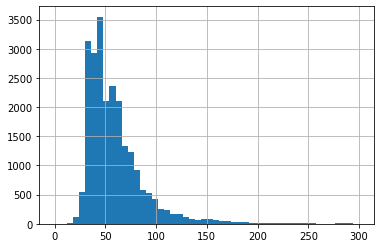

In [ ]:
real['total_area'].hist( range = (0, 300),bins = 50)
plt.show('Общая площадь')

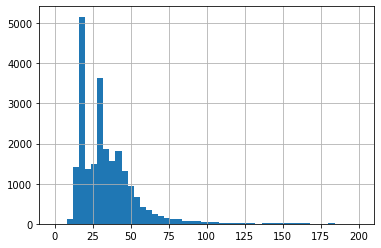

In [ ]:
real['living_area'].hist(range = (0, 200),bins = 50)
plt.show('Жилая площадь')

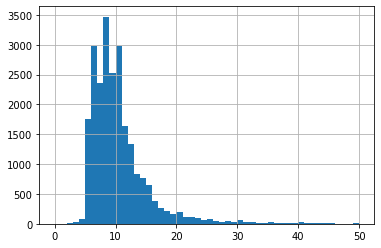

In [ ]:
real['kitchen_area'].hist(range = (0, 50),bins = 50)
plt.show('Площадь кухни')

<div class="alert alert-block alert-info">
1) Общая площадь отражается вполне корректно - большинство квартир в продаже около 50м2, а больше 150м2 квартиры - это штучный товар.
    
2) Замечено странный пик в районе 12м2 - крайне мало как для среднестатистической 50м2 квартиры - второй пик в районе 30-32м2 более характерен.
    
3) В гистрограмме площади кухонь всё резонно - имеется несколько пиков, связанных с типовыми планировками от советского союза, где площадь четко равна определенным типовым значения ( 7, 9, 12м2)</div>

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Рекомендация на будущее: лучше под каждым графиком оставлять комментарии, чтобы клиенту не пришлось мотать туда-сюда страницу/презентацию. Сами графики желательно подписывать (оси + заголовок).</div>

<h4><div class="alert alert-block alert-info">
Время продажи квартир
  </div></h4>

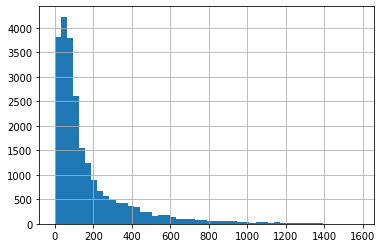

In [ ]:
real['days_exposition'].hist(range = (0,1580), bins = 50)
plt.show()

In [ ]:
real['days_exposition'].describe()

count    23641.000000
mean       172.083076
std        208.040714
min          1.000000
25%         45.000000
50%         94.000000
75%        206.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [ ]:
real['days_exposition'].median()

94.0

In [ ]:
real['days_exposition'].mean()

172.08307601201304

<div class="alert alert-block alert-info">
Исходя из гистограммы, а также глядя на средние и медианные значения делаю следующие выводы:
    
1) средний срок продажи - 94 дня или 3 месяца
    
2) чрезвычайно успешная продажа - меньше 45 дней. Всего 25% от общего количества выборки. Однако на графике около нуля есть необычный пик с которым нужно разобраться.
    
3) Есть большое отклонение между средним значением (172 дня в продаже) и медианным.Скорее всего дело в нескольких излишне больших показателях.
    
4) Всё, что в продаже больше 400 дней - является практически в четыре раза дольше среднестатистической продажи. Дальше - уже ненормально.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Согласна. </div>

<h4><div class="alert alert-block alert-info">
Убираем выбивающиеся значения.
  </div></h4>

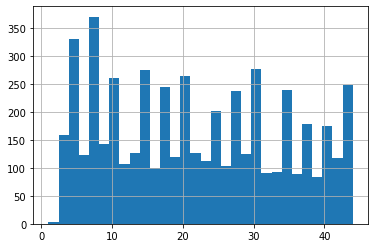

In [ ]:
real['days_exposition'][real['days_exposition'] < 45].hist(bins = 30)
plt.show("график")

<div class="alert alert-block alert-info">
По самым быстрым продажам каких-либо аномалий не вижу.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Есть продажи, совершенные за пару. Но я не думаю, что это основание для удаления данных. У нас есть и другие, более весомые аномалии в данных.</div>

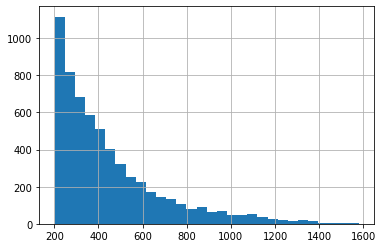

In [ ]:
real['days_exposition'][real['days_exposition'] > 200].hist(bins = 30)
plt.show("график")

In [ ]:
real[real['days_exposition'] > 200]['days_exposition'].describe()

count    6075.000000
mean      447.237531
std       243.468198
min       201.000000
25%       269.000000
50%       370.000000
75%       546.000000
max      1580.000000
Name: days_exposition, dtype: float64

<div class="alert alert-block alert-info">
Больше 400 дней (больше года!) - предельное значение, дольше которого выборку стоит отсеять.
</div>

In [ ]:
real['last_price'].describe()

count     23641.00000
mean       6525.75873
std       10805.78664
min          12.19000
25%        3420.00000
50%        4650.00000
75%        6800.00000
max      763000.00000
Name: last_price, dtype: float64

In [ ]:
real[real['rooms'] > 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor,living_to_total,kitchen_to_total
52,20,11795.0,136.0,2017-09-22T00:00:00,6,3.000,2,94.00,2,True,...,729,165,2017-09-22,86.73,4,9,2017,последний,0.69,0.08
201,5,10880.0,123.1,2015-11-12T00:00:00,6,3.200,5,89.00,2,True,...,729,992,2015-11-12,88.38,3,11,2015,другой,0.72,0.09
464,15,66571.0,280.3,2015-06-11T00:00:00,6,5.200,8,159.50,7,True,...,616,578,2015-06-11,237.50,3,6,2015,другой,0.57,0.08
509,5,90000.0,225.0,2016-06-26T00:00:00,6,3.330,4,134.00,2,True,...,519,416,2016-06-26,400.00,6,6,2016,другой,0.60,0.09
581,20,65000.0,365.0,2019-03-18T00:00:00,7,2.900,7,101.00,7,True,...,58,46,2019-03-18,178.08,0,3,2019,последний,0.28,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,20,24800.0,231.2,2015-01-21T00:00:00,6,3.100,5,99.80,4,True,...,795,467,2015-01-21,107.27,2,1,2015,другой,0.43,0.12
23395,4,40000.0,188.0,2017-05-29T00:00:00,6,3.475,6,109.51,4,True,...,62,30,2017-05-29,212.77,0,5,2017,другой,0.58,0.17
23400,17,30000.0,213.0,2017-09-28T00:00:00,7,3.400,5,151.40,5,True,...,30,299,2017-09-28,140.85,3,9,2017,последний,0.71,0.14
23448,3,14700.0,180.0,2018-02-08T00:00:00,6,3.000,6,126.00,5,True,...,616,76,2018-02-08,81.67,3,2,2018,другой,0.70,0.11


In [ ]:
len(real)

23641

In [ ]:
good_real = real.query('days_exposition < 400 and last_price > 2000 < 15000 and total_area > 20 < 400 and rooms < 5')
len(good_real)

19241

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Проверим себя: </div>

In [ ]:
# КОД РЕВЬЮЕРА

good_real[['last_price', 'total_area','rooms', 'ceiling_height' ]].describe().loc[['min', 'max']]

,last_price,total_area,rooms,ceiling_height
min,2006.0,20.1,0.0,2.25
max,330000.0,500.0,4.0,4.80


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Да, вроде бы все отлично :)  </div>

<h4><div class="alert alert-block alert-info">
Изучаем корреляцию
  </div></h4>

<h6><div class="alert alert-block alert-info">
Отношение цены к площади, количеству комнат и близости к центру.
  </div></h6>

In [ ]:
columns = ['last_price','rooms','total_area','cityCenters_nearest']
corr = pd.DataFrame(good_real, columns=columns)
corr.head()

,last_price,rooms,total_area,cityCenters_nearest
0,13000.0,3,108.0,16028
1,3350.0,1,40.4,18603
4,10000.0,2,100.0,8098
5,2890.0,1,30.4,16293
6,3700.0,1,37.3,19143


In [ ]:
corr.corr()

,last_price,rooms,total_area,cityCenters_nearest
last_price,1.000000,0.323112,0.654979,-0.255971
rooms,0.323112,1.000000,0.715621,-0.119624
total_area,0.654979,0.715621,1.000000,-0.200933
cityCenters_nearest,-0.255971,-0.119624,-0.200933,1.000000


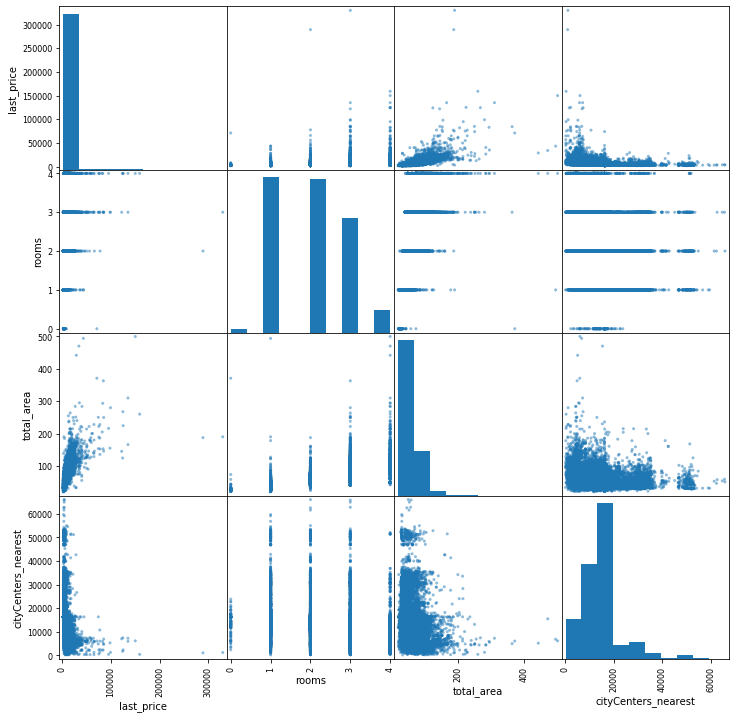

In [ ]:
pd.plotting.scatter_matrix(corr, figsize=(12, 12))
plt.show()

<div class="alert alert-block alert-info">
Изучив корреляцию цены к количеству комнат, площади и близости к центру увидели следующее:
1) Корреляция цены к площади и количеству комнат прямая - чем больше комнат, тем больше цена.
2) Корреляция близости к центру предсказуемо обратная - выше всего цена и что более интересно площади квартир, которые находятся ближе к центру.
    
</div>

<h6><div class="alert alert-block alert-info">
Зависимость цены от этажа, на котором находится квартира.
  </div></h6>

In [ ]:
good_real.plot(y = 'last_price', x = 'which_floor', kind = 'scatter')
plt.show()

ValueError: scatter requires x column to be numeric

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера 2</h2>
    
Здесь не отображается ячейка. Перестрою:</div>

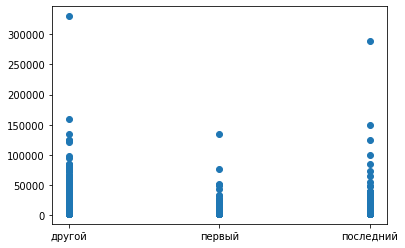

In [ ]:
# КОД РЕВЬЮЕРА

plt.scatter(good_real['which_floor'], good_real['last_price'])

<div class="alert alert-block alert-info">
C учетом актуальных реалий высотного строительства экстраординарные цены встречаются на последних этажах, тн "пентхаусах", в остальном же более высокий потолок цен встречается у средних этажей, а на первом цены значительно ниже
  </div>

<h6><div class="alert alert-block alert-info">
Зависимость от даты размещения:
  </div></h6>

<h6><div class="alert alert-block alert-info">
День недели:
  </div></h6>

In [ ]:
good_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19241 entries, 0 to 23696
Data columns (total 30 columns):
total_images            19241 non-null int64
last_price              19241 non-null float64
total_area              19241 non-null float64
first_day_exposition    19241 non-null object
rooms                   19241 non-null int64
ceiling_height          19241 non-null float64
floors_total            19241 non-null int64
living_area             19241 non-null float64
floor                   19241 non-null int64
is_apartment            19241 non-null bool
studio                  19241 non-null bool
open_plan               19241 non-null bool
kitchen_area            19241 non-null float64
balcony                 19241 non-null int64
locality_name           19203 non-null object
airports_nearest        19241 non-null int64
cityCenters_nearest     19241 non-null int64
parks_around3000        19241 non-null int64
parks_nearest           19241 non-null int64
ponds_around3000        192

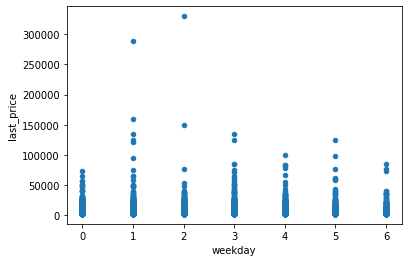

-0.005830392941626698

In [ ]:
good_real.plot(y = 'last_price', x = 'weekday', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['weekday'])

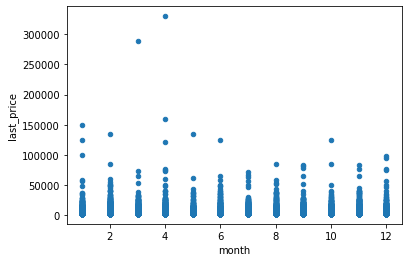

-0.009100731334277815

In [ ]:
good_real.plot(y = 'last_price', x = 'month', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['month'])

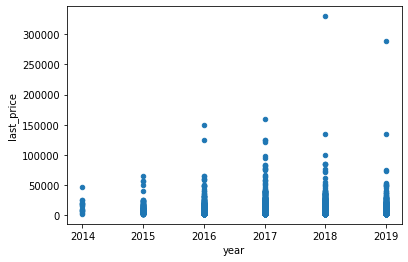

-0.006786645186143576

In [ ]:
good_real.plot(y = 'last_price', x = 'year', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['year'])

<div class="alert alert-block alert-info">
Что касается дня недели - то корреляция от дня ко дню отсутствует.
То же самое можно сказать по поводу месяцев, вопреки устойчивому слуху о сезонности роста цен.
А вот годовая корреляция четко показывает что цены в 2017 году были максимальными по сравнению с предыдущими и последующими годами и сейчас тенденция идет на снижение.
  </div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Картина с месяцем и днем недели тянет на случайность. Ведь речь идет о дате размещения и о цене продажи. Разместить можно во вторник в мае, а продать в пятницу в ноябре, по более низкой цене. Это можно даже проверить, построив точно такие же графики для разных лет. Наверняка ситуация будет меняться. А вот год - да, вполне может влиять. Из года в год экономическая ситуация меняется, а вместе с ней и покупательская способность.
</div>

<h6><div class="alert alert-block alert-info">
Средняя стоимость и цена квадратного метра в 10 крупнейших городах
  </div></h6>

In [ ]:
local_name = good_real.pivot_table(
    index='locality_name', values='last_price', aggfunc='count'
)
local_name.columns = [ 'count']

good_names = local_name.query('count >= 175')
good_names['count'].sum()


#good_stat2 = station_stat_full.query('count > 30').pivot_table(
    #index='name', values='time_spent', aggfunc=['median', 'count']
#)

16233

In [ ]:
top10towns = good_real.query('locality_name in @good_names.index')
top10towns

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor,living_to_total,kitchen_to_total
0,20,13000.0,108.00,2019-03-07T00:00:00,3,2.700,16,51.0,8,True,...,755,141,2019-03-07,120.37,3,3,2019,другой,0.47,0.23
1,7,3350.0,40.40,2018-12-04T00:00:00,1,2.700,11,18.6,1,True,...,729,81,2018-12-04,82.92,1,12,2018,первый,0.46,0.27
4,2,10000.0,100.00,2018-06-19T00:00:00,2,3.030,14,32.0,13,True,...,48,121,2018-06-19,100.00,1,6,2018,другой,0.32,0.41
6,6,3700.0,37.30,2017-11-02T00:00:00,1,2.650,26,10.6,6,True,...,729,155,2017-11-02,99.20,3,11,2017,другой,0.28,0.39
7,5,7915.0,71.60,2019-04-18T00:00:00,2,2.775,24,44.3,22,True,...,729,92,2019-04-18,110.54,3,4,2019,другой,0.62,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200.0,39.00,2017-12-16T00:00:00,1,2.650,9,20.0,6,True,...,729,38,2017-12-16,82.05,5,12,2017,другой,0.51,0.28
23688,19,9200.0,101.00,2019-04-01T00:00:00,3,3.050,15,63.0,12,True,...,729,23,2019-04-01,91.09,0,4,2019,другой,0.62,0.15
23689,13,3550.0,35.30,2018-02-28T00:00:00,1,2.860,15,16.3,4,True,...,652,29,2018-02-28,100.57,2,2,2018,другой,0.46,0.26
23690,3,5500.0,52.00,2018-07-19T00:00:00,2,2.600,5,31.0,2,True,...,729,15,2018-07-19,105.77,3,7,2018,другой,0.60,0.12


In [ ]:
columns = ['locality_name','last_price', 'square_metr']
most_expensive = pd.DataFrame(top10towns, )
most_expensive

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,time_to_day,square_metr,weekday,month,year,which_floor,living_to_total,kitchen_to_total
0,20,13000.0,108.00,2019-03-07T00:00:00,3,2.700,16,51.0,8,True,...,755,141,2019-03-07,120.37,3,3,2019,другой,0.47,0.23
1,7,3350.0,40.40,2018-12-04T00:00:00,1,2.700,11,18.6,1,True,...,729,81,2018-12-04,82.92,1,12,2018,первый,0.46,0.27
4,2,10000.0,100.00,2018-06-19T00:00:00,2,3.030,14,32.0,13,True,...,48,121,2018-06-19,100.00,1,6,2018,другой,0.32,0.41
6,6,3700.0,37.30,2017-11-02T00:00:00,1,2.650,26,10.6,6,True,...,729,155,2017-11-02,99.20,3,11,2017,другой,0.28,0.39
7,5,7915.0,71.60,2019-04-18T00:00:00,2,2.775,24,44.3,22,True,...,729,92,2019-04-18,110.54,3,4,2019,другой,0.62,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200.0,39.00,2017-12-16T00:00:00,1,2.650,9,20.0,6,True,...,729,38,2017-12-16,82.05,5,12,2017,другой,0.51,0.28
23688,19,9200.0,101.00,2019-04-01T00:00:00,3,3.050,15,63.0,12,True,...,729,23,2019-04-01,91.09,0,4,2019,другой,0.62,0.15
23689,13,3550.0,35.30,2018-02-28T00:00:00,1,2.860,15,16.3,4,True,...,652,29,2018-02-28,100.57,2,2,2018,другой,0.46,0.26
23690,3,5500.0,52.00,2018-07-19T00:00:00,2,2.600,5,31.0,2,True,...,729,15,2018-07-19,105.77,3,7,2018,другой,0.60,0.12


In [ ]:
most_expensive2 = most_expensive.pivot_table(index = 'locality_name', values = ('last_price','square_metr'), aggfunc = 'mean')
#most_expensive2.columns ( columns = ['last_price', 'square_metr'])
most_expensive2.sort_values(by = 'last_price', ascending = False).round(0)

,last_price,square_metr
locality_name,,
Санкт-Петербург,7100.0,113.0
Пушкин,5948.0,103.0
посёлок Парголово,4526.0,90.0
деревня Кудрово,4286.0,93.0
посёлок Шушары,4106.0,79.0
Всеволожск,3959.0,70.0
Колпино,3838.0,75.0
посёлок Мурино,3691.0,86.0
Гатчина,3609.0,71.0


<div class="alert alert-block alert-info">
Предсказуемо самое дорогое место для покупки жилья - это Санкт-Петербург. Далее идет г.Пушкин, а на 3 месте поселок.
Худшим среди лучших является г.Выборг, с ценой в 2 раза меньше чем в Питере
  </div>

In [ ]:
piter = good_real.query('locality_name == "Санкт-Петербург"')
piter['cityCenters_nearest_km'] = (piter['cityCenters_nearest']/ 1000).round(0)
center = piter.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = 'mean')
center

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,last_price
cityCenters_nearest_km,
0.0,33518.027778
1.0,19355.793540
2.0,14154.778148
3.0,9395.374307
4.0,10214.817229
5.0,11620.018398
6.0,12370.552367
7.0,12860.103598
8.0,8733.140226


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Кстати, предупреждения можно отключать:
</div>

```python

import warnings

warnings.filterwarnings('ignore')
```

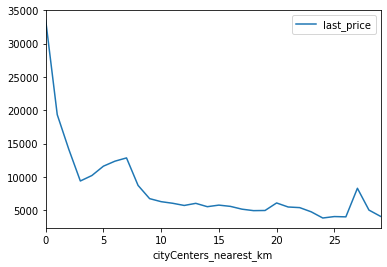

In [ ]:
center.plot()
plt.show()

<div class="alert alert-block alert-info">
Судя по графику, радиус центра в Питере - 3 км. После этого имеется интересный скачок в цене на уровне 7 км и затем цены идут значительно ниже.
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Совершенно верно.</div>



<h6><div class="alert alert-block alert-info">
Изучаем сегмент квартир в центре города Санкт-Петербург
  </div></h6>

In [ ]:
piter_center = piter.query('cityCenters_nearest_km <= 3')
piter_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 24 to 23602
Data columns (total 31 columns):
total_images              609 non-null int64
last_price                609 non-null float64
total_area                609 non-null float64
first_day_exposition      609 non-null object
rooms                     609 non-null int64
ceiling_height            609 non-null float64
floors_total              609 non-null int64
living_area               609 non-null float64
floor                     609 non-null int64
is_apartment              609 non-null bool
studio                    609 non-null bool
open_plan                 609 non-null bool
kitchen_area              609 non-null float64
balcony                   609 non-null int64
locality_name             609 non-null object
airports_nearest          609 non-null int64
cityCenters_nearest       609 non-null int64
parks_around3000          609 non-null int64
parks_nearest             609 non-null int64
ponds_around3000          60

In [ ]:
columns = ['total_area','rooms', 'last_price','ceiling_height','floor','cityCenters_nearest_km','time_to_day']
piter_center2 = pd.DataFrame(piter_center, columns = columns)
piter_center2

,total_area,rooms,last_price,ceiling_height,floor,cityCenters_nearest_km,time_to_day
24,97.2,2,6500.0,2.725,1,2.0,2015-10-31
99,90.0,4,9600.0,2.800,2,3.0,2017-09-26
138,40.0,2,4800.0,2.700,2,3.0,2017-11-18
154,80.0,3,8200.0,4.150,2,3.0,2018-11-06
179,108.7,3,14800.0,4.000,5,3.0,2019-04-11
...,...,...,...,...,...,...,...
23369,129.0,3,20900.0,3.020,7,2.0,2016-05-13
23387,50.0,1,5600.0,2.600,1,3.0,2017-08-21
23399,97.0,3,15300.0,3.500,2,1.0,2017-01-11
23430,38.0,1,5260.0,3.300,1,3.0,2018-11-06


<div class="alert alert-block alert-info">
Изучим общую площадь, представленную в центре.
</div>

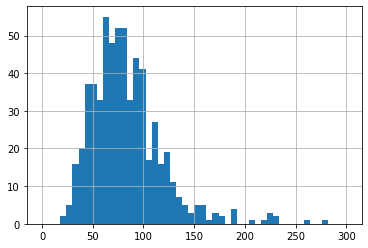

In [ ]:
piter_center2['total_area'].hist( range = (0, 300),bins = 50)
plt.show()

In [ ]:
piter_center2['total_area'].describe()

count    609.000000
mean      82.932315
std       35.410697
min       22.700000
25%       60.000000
50%       77.800000
75%       98.400000
max      280.000000
Name: total_area, dtype: float64

<div class="alert alert-block alert-info">
Вопреки ожиданиям о большом количестве доходной недвижимости маленькой площади, наибольшее количество квартир обладает площадью от 70 до 100м2,

посмотрим как эта площадь отражается в количестве комнат.
</div>

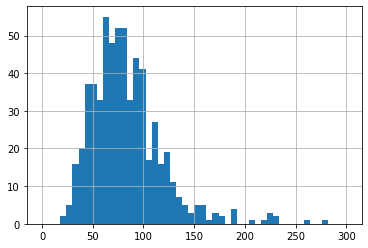

In [ ]:
piter_center2['total_area'].hist( range = (0, 300),bins = 50)
plt.show()


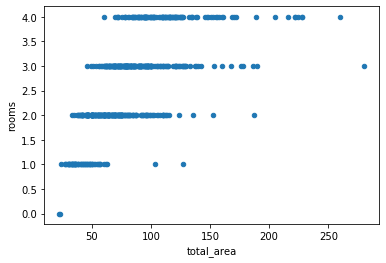

In [ ]:
piter_center2.plot(y = 'rooms', x = 'total_area', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
И опять на графике видим, что преобладают 3 и 4 комнатные квартиры большей площади. Видимо наследие былых времен с царскими амбициями.
</div>

<div class="alert alert-block alert-info">
Изучим, насколько цена зависит от близости к центральной точке, "нулевому" километру.
</div>

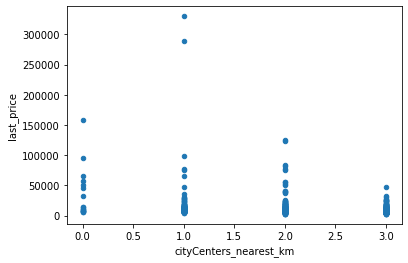

In [ ]:
piter_center2.plot(y = 'last_price', x = 'cityCenters_nearest_km', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
Как видим - на любом километре распределение цены примерно схожее - центр и есть центр в любой из этих точек.
</div>

<div class="alert alert-block alert-info">
Центр славится высокими потолками, как элементом престижа. Так ли это на самом деле?
</div>

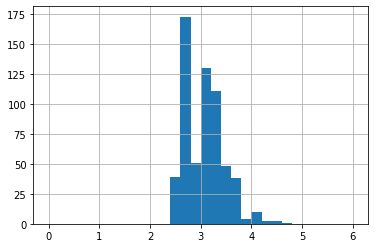

In [ ]:
piter_center2['ceiling_height'].hist( range = (0, 6),bins = 30)
plt.show()



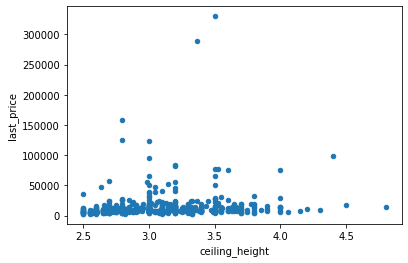

In [ ]:
piter_center2.plot(y = 'last_price', x = 'ceiling_height', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
На гистограмме имеется 2 характерных пика - на отметке типовых 2.7м, которые скорее всего относятся к более современным постройкам, и чуть больше 3метров (3.10-3.30м) которые отражают сталинские и довоенные дома.
    
Что касается корреляции с ценой, то потолок не является определяющим фактором цены. Место, место и ещё раз место.
</div>

<div class="alert alert-block alert-info">
Отношение цены и этажа квартиры.
</div>

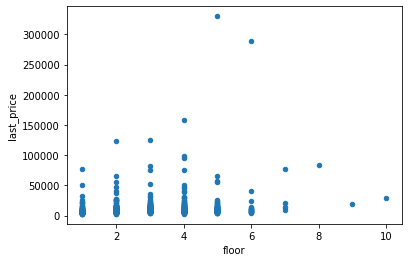

In [ ]:
piter_center2.plot(y = 'last_price', x = 'floor', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
Как видим из результата, высоких зданий в центре практически нет и каждый ценит свой - кто-то первый для бизнеса, кому-то легче на второй подниматься, а выше 4-ого - уже "видовые".
</div>

<h7><div class="alert alert-block alert-info">
Изменение цены во времени
  </div></h7>

<h7><div class="alert alert-block alert-info">
Среди факторов теоретически влияющих на стоимость объекта в центре мы отмели высоту потолков и увеличение цены по мере приближения к центральной точке. Но как насчет поверья, что недвижимость в центре только дорожает?
  </div></h7>

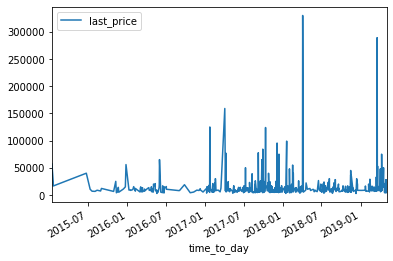

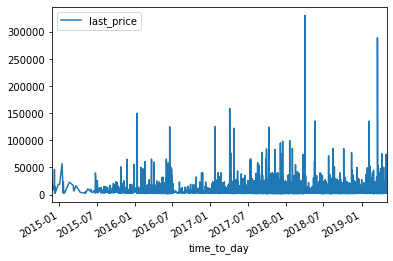

In [ ]:
piter_center2.plot(y = 'last_price', x = 'time_to_day')
good_real.plot(y = 'last_price', x = 'time_to_day')
plt.show()

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Такой график получился из-за большого числа значений. Тут можно построить точечную диаграмму или же график прямой, который покажет зависимость медианы цены от даты размещения.</div>

<h7><div class="alert alert-block alert-info">
Как и в целом по рынку, основной пик был в середине 2017 и затем цены немного снизились, за исключением нескольких экстраординарных сделок.
  </div></h7>

 <strong><em><h1>
Шаг 5 общие выводы. </em></strong></h1>

<h7><div class="alert alert-block alert-info">
На удивление мало факторов влияет на стоимость объекта недвижимости по-настоящему.
Первый фактор это месторасположение. Питер стоит значительно дороже пригорода, центр превосходит любой спальный район.
Второй фактор это общее экономическое положение, как внешний фактор. Если есть спрос, то он влияет на все цены, если спроса нет, то цена падает на всю недвижимость и этажность, площадь и тому подобное не влияет.

  </div></h7>

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Вывод хороший. В идеале стоит подкреплять его полученными ранее результаты. Здесь же можно добавить медианы основных характеристик квартир для центра и для всей выборки, чтобы заказчику было понятно не только то, что квартиры в центре больше и дороже, но и насколько они больше и насколько дороже.
</div>